# All imports

In [0]:
! pip install implicit

     |████████████████████████████████| 1.1MB 6.8MB/s 
  Created wheel for implicit: filename=implicit-0.4.2-cp36-cp36m-linux_x86_64.whl size=3472942 sha256=06e413dabce426ed3e390e5a984d475f96a3b87c04f810b4527ae4136e2498e0
  Stored in directory: /root/.cache/pip/wheels/1b/48/b1/1aebe3acc3afb5589e72d3e7c3ffc3f637dc4721c1a974dff7
Successfully built implicit


In [0]:
import implicit

In [0]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix, coo_matrix

from tqdm import tqdm
from copy import deepcopy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%matplotlib inline
sns.set_style('darkgrid')

# Load data

In [0]:
if not os.path.exists('./data'):
  os.mkdir('./data')

gdd.download_file_from_google_drive(file_id='1r6U_EFULKXiuLPrIEAdoJ7W_1Xa7aJ3Q', dest_path='./data/movies.zip')

In [0]:
! unzip ./data/movies.zip -d ./data/unziped

Archive:  ./data/movies.zip
  inflating: ./data/unziped/links.csv  
  inflating: ./data/unziped/movies.csv  
  inflating: ./data/unziped/ratings.csv  
  inflating: ./data/unziped/tags.csv  
  inflating: ./data/unziped/u.data   


# EDA

In [0]:
ratings_df = pd.read_csv('/content/data/unziped/ratings.csv')

In [0]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [0]:
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

In [0]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,2009-12-14 02:52:24
1,1,1029,3.0,2009-12-14 02:52:59
2,1,1061,3.0,2009-12-14 02:53:02
3,1,1129,2.0,2009-12-14 02:53:05
4,1,1172,4.0,2009-12-14 02:53:25


Check nans

In [0]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100004 non-null  int64         
 1   movieId    100004 non-null  int64         
 2   rating     100004 non-null  float64       
 3   timestamp  100004 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.1 MB


In [0]:
ratings_df['userId'].nunique()

671

In [0]:
ratings_df['movieId'].nunique()

9066

Sparcity

In [0]:
ratings_df.shape[0] / (ratings_df['userId'].nunique() * ratings_df['movieId'].nunique())

0.016439141608663475

Ratings distribution over users

Text(0.5, 0, 'number of ratings per user')

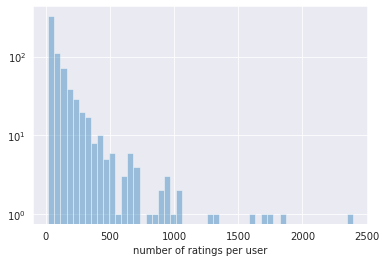

In [0]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
sns.distplot(ratings_df.groupby('userId').agg({'rating':'count'}),ax=ax,kde=False)
ax.set_yscale('log')
ax.set_xlabel("number of ratings per user")

Ratings distribution over movies

Text(0.5, 0, 'number of ratings per movie')

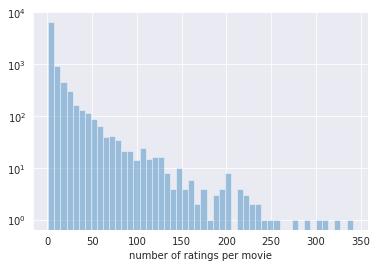

In [0]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
sns.distplot(ratings_df.groupby('movieId').agg({'rating':'count'}),ax=ax,kde=False)
ax.set_yscale('log')
ax.set_xlabel("number of ratings per movie")

# Dataset preprocessing

Let's transform it from explicit to implicit due to following rule:

1 if we have rating for pair (user, movie), 0 otherwise

In [0]:
ratings_df['rating'] = 1

In [0]:
ratings_per_user = ratings_df.groupby('userId').agg({'rating':'count'}).reset_index().rename(columns={'rating':'rating_num'})

There is no need in removing any users, there are no cold users.

In [0]:
ratings_per_user['rating_num'].min()

20

In [0]:
ratings_per_movie = ratings_df.groupby('movieId').agg({'rating':'count'}).reset_index().rename(columns={'rating':'rating_num'})

In [0]:
ratings_per_movie['rating_num'].min()

1

In [0]:
ratings_df.rename(columns={'movieId':'itemId'}, inplace=True)

In [0]:
def classical_data_split(X):
  train_and_val_df, test_df = train_test_split(X, test_size=0.1)
  train_df, val_df = train_test_split(train_and_val_df, train_size=7/9)
  return train_df, val_df, test_df

In [0]:
train_df, val_df, test_df = classical_data_split(ratings_df)

# Most popular recommender

In [0]:
class MostPopularRecommender():
  def __init__(self):
    self.sorted_items = None

  def fit(self, X):
    """Build list of items according to their popularity

    :param X: incoming data for fitting contains 'userId' and 'itemId' columns (DataFrame)
    """
    self.sorted_items = X.groupby('itemId').agg({'rating':'count'}).sort_values(by='rating', ascending=False).reset_index()['itemId'].tolist()
  
  def predict(self, X, top_n):
    """Predict top_n popular items for each user
    
    :param X: incoming data for prediction contains 'userId' column (DataFrame)
    :param top_n: number of recommendations (int)
    :return: items recommendations for each user (DataFrame)
    """
    prediction_df = pd.DataFrame()
    prediction_df['userId'] = X['userId'].unique()
    prediction_df['rec_items'] = [self.sorted_items[:top_n] for _ in range(X['userId'].nunique())]
    return prediction_df

# KNN User-based

In [0]:
class KNNUserBased():
  def __init__(self, n_neighbors):
    self.n_neighbors = n_neighbors
    self.user_item_matrix = None
    self.model_knn = None

  def fit(self, X):
    """Build user-item matrix and train KNN for users

    :param X: incoming data for fitting contains 'userId', 'itemId' and 'rating' columns (DataFrame)
    """
    self.user_item_matrix = X.pivot(index='userId',
                               columns='itemId',
                               values='rating'
                              ).fillna(0)
    self.model_knn = NearestNeighbors(metric='cosine', algorithm='kd_tree', n_neighbors=self.n_neighbors, n_jobs=-1)
    self.model_knn.fit(self.user_item_matrix)

  def predict(self, X):
    pass

In [0]:
user_item_matrix = train_df.pivot(index='userId',
                               columns='itemId',
                               values='rating'
                              ).fillna(0).values
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)
model_knn.fit(user_item_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
                 radius=1.0)

In [0]:
user_to_idx = {u:idx for idx, u in enumerate(sorted(train_df['userId'].unique()))}
idx_to_user = {idx:u for u, idx in user_to_idx.items()}
item_to_idx = {i:idx for idx, i in enumerate(sorted(train_df['itemId'].unique()))}
idx_to_item = {idx:i for i, idx in item_to_idx.items()}

In [0]:
predicted_df = pd.DataFrame()
predicted_df['userId'] = list(set(test_df['userId'].unique()) & set(train_df['userId'].unique()))
predicted_df['rec_items'] = 0
predicted_df.set_index('userId', inplace=True)
predicted_df = predicted_df.astype('object')

In [0]:
for user in tqdm(test_df['userId'].unique()):
  if user in train_df['userId'].unique():
    user_vector = user_item_matrix[user_to_idx[user],:]
    distances, neighbours = model_knn.kneighbors(user_vector.reshape(1,-1))
    similar_users_indices = neighbours[0].tolist()
    distances_tiled = np.tile(distances[0], train_df['itemId'].nunique()).reshape(10,train_df['itemId'].nunique())
    scores = np.sum(user_item_matrix[similar_users_indices,:] * distances_tiled, axis=0) / np.sum(distances[0])
    best_items_idx = scores.argsort()[::-1].tolist()
    best_items = []
    for item_idx in best_items_idx:
      if item_idx not in train_df[train_df['userId'] == user]['itemId'].unique():
        best_items.append(idx_to_item[item_idx])
      if len(best_items) == 5:
        break

    #best_items = [idx_to_item[idx] for idx in best_items_idx]
    predicted_df.at[user, 'rec_items'] = best_items





  0%|          | 0/659 [00:00<?, ?it/s]


  0%|          | 1/659 [00:00<01:19,  8.30it/s]


  0%|          | 2/659 [00:00<01:22,  7.96it/s]


  0%|          | 3/659 [00:00<01:23,  7.88it/s]


  1%|          | 4/659 [00:00<01:23,  7.86it/s]


  1%|          | 5/659 [00:00<01:23,  7.87it/s]


  1%|          | 6/659 [00:00<01:21,  7.99it/s]


  1%|          | 7/659 [00:00<01:20,  8.05it/s]


  1%|          | 8/659 [00:01<01:20,  8.10it/s]


  1%|▏         | 9/659 [00:01<01:21,  7.96it/s]


  2%|▏         | 10/659 [00:01<01:22,  7.89it/s]


  2%|▏         | 11/659 [00:01<01:22,  7.84it/s]


  2%|▏         | 12/659 [00:01<01:22,  7.86it/s]


  2%|▏         | 13/659 [00:01<01:21,  7.88it/s]


  2%|▏         | 14/659 [00:01<01:22,  7.86it/s]


  2%|▏         | 15/659 [00:01<01:22,  7.78it/s]


  2%|▏         | 16/659 [00:02<01:21,  7.85it/s]


  3%|▎         | 17/659 [00:02<01:22,  7.83it/s]


  3%|▎         | 18/659 [00:02<01:21,  7.86it/s]


  3%|▎         | 19/659 [00:02<01:21,  7.87it/

In [0]:
predicted_df.reset_index(inplace=True)

In [0]:
predicted_df

,userId,rec_items
0,1,"[1172, 1293, 1405, 3671, 1339]"
1,2,"[589, 296, 588, 356, 10]"
2,3,"[318, 6377, 356, 7153, 1196]"
3,4,"[1200, 590, 1136, 1291, 364]"
4,5,"[2355, 356, 1580, 364, 377]"
...,...,...
654,666,"[356, 590, 344, 150, 480]"
655,667,"[296, 161, 480, 357, 597]"
656,669,"[785, 2710, 2396, 2599, 2724]"
657,670,"[318, 296, 32, 150, 110]"


In [0]:
train_df.query

,userId,itemId,rating,timestamp
84923,570,1258,1,2016-10-06 20:05:06
10930,73,4734,1,2009-10-15 07:25:38
32579,235,3623,1,2005-03-23 06:05:15
49454,361,7,1,1997-05-19 14:13:17
56531,407,3174,1,2000-07-03 18:01:07
...,...,...,...,...
17422,115,2706,1,2005-01-29 21:34:31
49694,363,1037,1,1999-11-11 19:05:19
65956,468,1394,1,2011-01-28 06:34:59
50994,378,6870,1,2015-09-26 18:32:21


In [0]:
ground_truth_df = collect_ground_truth(test_df)

In [0]:
k=5
for metric_func in [precision_at_k, recall_at_k, hit_rate_at_k, ndcg_at_k, average_precision_at_k]:
  print('{:s}: {:f}'.format(metric_func.__name__, mean_metric(predicted_df, ground_truth_df,metric_func,k=k)))

precision_at_k: 0.014568
recall_at_k: 0.011896
hit_rate_at_k: 0.072838
ndcg_at_k: 0.010221
average_precision_at_k: 0.026505


# implicit ALS

In [0]:
class ALSRecommender():
  def __init__(self, factors):
    # dicts to store id <-> idx mappings
    self.user_to_idx = None
    self.idx_to_user = None
    self.item_to_idx = None
    self.idx_to_item = None

    self.factors = factors
    # initialize model
    self.model = implicit.als.AlternatingLeastSquares(factors=self.factors)

    self.train_users = None

  def fit(self, X):
    """Build user-item matrix and train ALS

    :param X: incoming data for fitting contains 'userId', 'itemId' and 'rating' columns (DataFrame)
    """
    # create copy to operate with
    X_copy = deepcopy(X)
    # this model need to store train users for correct prediction
    self.train_users = X_copy['userId'].unique()
    # create mappings
    self.user_to_idx = {u:idx for idx, u in enumerate(sorted(X_copy['userId'].unique()))}
    self.idx_to_user = {idx:u for u, idx in self.user_to_idx.items()}
    self.item_to_idx = {i:idx for idx, i in enumerate(sorted(X_copy['itemId'].unique()))}
    self.idx_to_item = {idx:i for i, idx in self.item_to_idx.items()}
    
    # map id on idx
    X_copy['userIdx'] = X_copy['userId'].apply(lambda x: self.user_to_idx[x])
    X_copy['itemIdx'] = X_copy['itemId'].apply(lambda x: self.item_to_idx[x])
    
    # build item-user matrix
    self.item_user_matrix = csr_matrix(X_copy.pivot(index='itemIdx',
                               columns='userIdx',
                               values='rating'
                              ).fillna(0).values)
    # fit model
    self.model.fit(self.item_user_matrix)
    
  def predict(self, X, top_n):
    """Predict top_n popular items for each user
    
    :param X: incoming data for prediction contains 'userId' column (DataFrame)
    :param top_n: number of recommendations (int)
    :return: items recommendations for each user (DataFrame)
    """
    predicted_df = pd.DataFrame()
    # prediction can be made only for users who are presented into train and test both
    predicted_df['userId'] = list(set(X['userId'].unique()) & set(self.train_users))
    # initialize column with nulls
    predicted_df['rec_items'] = 0
    # some tricks to assign lists to dataframe cells
    predicted_df.set_index('userId', inplace=True)
    predicted_df = predicted_df.astype('object')
    # required by ALS interface
    user_item_matrix = self.item_user_matrix.T.tocsr()

    for user in tqdm(X['userId'].unique()):
      if user in self.train_users:
        recommendations = self.model.recommend(self.user_to_idx[user], user_item_matrix, filter_already_liked_items=True, N=top_n)
        best_items = [self.idx_to_item[item] for (item, score) in recommendations]
        # use at to assign list
        predicted_df.at[user, 'rec_items'] = best_items
    predicted_df.reset_index(inplace=True)
    return predicted_df


# BPR

In [0]:
class BPRRecommender():
  def __init__(self, factors):
    # dicts to store id <-> idx mappings
    self.user_to_idx = None
    self.idx_to_user = None
    self.item_to_idx = None
    self.idx_to_item = None

    self.factors = factors
    # initialize model
    # it is impossible to use gpu version due to bug in library
    self.model = implicit.bpr.BayesianPersonalizedRanking(factors=self.factors, use_gpu=False, verify_negative_samples=True)

    self.train_users = None

  def fit(self, X):
    """Build user-item matrix and train BPR

    :param X: incoming data for fitting contains 'userId', 'itemId' and 'rating' columns (DataFrame)
    """
    # create copy to operate with
    X_copy = deepcopy(X)
    # this model need to store train users for correct prediction
    self.train_users = X_copy['userId'].unique()
    # create mappings
    self.user_to_idx = {u:idx for idx, u in enumerate(sorted(X_copy['userId'].unique()))}
    self.idx_to_user = {idx:u for u, idx in self.user_to_idx.items()}
    self.item_to_idx = {i:idx for idx, i in enumerate(sorted(X_copy['itemId'].unique()))}
    self.idx_to_item = {idx:i for i, idx in self.item_to_idx.items()}
    
    # map id on idx
    X_copy['userIdx'] = X_copy['userId'].apply(lambda x: self.user_to_idx[x])
    X_copy['itemIdx'] = X_copy['itemId'].apply(lambda x: self.item_to_idx[x])
    
    # build item-user matrix
    self.item_user_matrix = coo_matrix(X_copy.pivot(index='itemIdx',
                               columns='userIdx',
                               values='rating'
                              ).fillna(0).values)
    # fit model
    self.model.fit(self.item_user_matrix)
    
  def predict(self, X, top_n):
    """Predict top_n popular items for each user
    
    :param X: incoming data for prediction contains 'userId' column (DataFrame)
    :param top_n: number of recommendations (int)
    :return: items recommendations for each user (DataFrame)
    """
    predicted_df = pd.DataFrame()
    # prediction can be made only for users who are presented into train and test both
    predicted_df['userId'] = list(set(X['userId'].unique()) & set(self.train_users))
    # initialize column with nulls
    predicted_df['rec_items'] = 0
    # some tricks to assign lists to dataframe cells
    predicted_df.set_index('userId', inplace=True)
    predicted_df = predicted_df.astype('object')
    # required by ALS interface
    user_item_matrix = self.item_user_matrix.T.tocsr()

    for user in tqdm(X['userId'].unique()):
      if user in self.train_users:
        recommendations = self.model.recommend(self.user_to_idx[user], user_item_matrix, filter_already_liked_items=True, N=top_n)
        best_items = [self.idx_to_item[item] for (item, score) in recommendations]
        # use at to assign list
        predicted_df.at[user, 'rec_items'] = best_items
    predicted_df.reset_index(inplace=True)
    return predicted_df

# Metrics

In [0]:
def collect_ground_truth(X):
  """Build list of ground truth for every user based on X provided data"""
  
  return X.groupby('userId').agg({'itemId':list}).reset_index().rename(columns={'itemId':'ground_truth_items'})

In [0]:
def precision_at_k(predicted, ground_truth, k):
  assert len(predicted) >= k
  intersection = set(predicted[:k]) & set(ground_truth)
  return len(intersection) / k

In [0]:
def recall_at_k(predicted, ground_truth, k):
  assert len(predicted) >= k
  intersection = set(predicted[:k]) & set(ground_truth)
  return len(intersection) / len(ground_truth)

In [0]:
def hit_rate_at_k(predicted, ground_truth, k):
  assert len(predicted) == k
  intersection = set(predicted[:k]) & set(ground_truth)
  return 1 if len(intersection) > 0 else 0

In [0]:
def ndcg_at_k(predicted, ground_truth, k):
  assert len(predicted) >= k
  gain = sum([1/np.log2(i+2) for i, item in enumerate(predicted[:k]) if item in ground_truth])
  max_gain = sum([1/np.log2(i+2) for i in range(len(ground_truth))])
  return gain / max_gain

In [0]:
def average_precision_at_k(predicted, actual, k):
  tmp = 0
  actual_length = min(k,len(actual))
  if len(predicted) < actual_length:
    warnings.warn("Length of predict is less than k")
  for i in range(actual_length):
    if predicted[i] in actual:
      tmp += precision_at_k(predicted[:i+1], actual, i+1)
  return tmp / actual_length

In [0]:
def average_precision_at_k(predicted, ground_truth, k):
  if len(set(predicted) & set(ground_truth)) == 0:
    return 0
  else:
    return np.mean([precision_at_k(predicted[:i+1], ground_truth, i+1) for i in range(k) if predicted[i] in ground_truth])

In [0]:
def mean_metric(predicted_df, ground_truth_df, metric_func, k):
  """Calculate averaged by users score for passed metric"""
  merged_df = pd.merge(ground_truth_df, predicted_df, on='userId')
  return np.mean([metric_func(row['rec_items'], row['ground_truth_items'], k=k) for _, row in  merged_df.iterrows()])

# Evaluation

In [0]:
k = 5

In [0]:
ground_truth_df = collect_ground_truth(test_df)

In [0]:
mp_rec = MostPopularRecommender()
mp_rec.fit(train_df)
predicted_df = mp_rec.predict(test_df, top_n=k)

In [0]:
for metric_func in [precision_at_k, recall_at_k, hit_rate_at_k, ndcg_at_k, average_precision_at_k]:
  print('{:s}: {:f}'.format(metric_func.__name__, mean_metric(predicted_df, ground_truth_df,metric_func,k=k)))

precision_at_k: 0.046483
recall_at_k: 0.030537
hit_rate_at_k: 0.197248
ndcg_at_k: 0.032528
average_precision_at_k: 0.098620


In [0]:
als_rec = ALSRecommender(30)
als_rec.fit(train_df)
predicted_df = als_rec.predict(test_df, top_n=k)

  8%|▊         | 50/654 [00:00<00:01, 496.26it/s]

100%|██████████| 654/654 [00:00<00:00, 1118.32it/s]


In [0]:
for metric_func in [precision_at_k, recall_at_k, hit_rate_at_k, ndcg_at_k, average_precision_at_k]:
  print('{:s}: {:f}'.format(metric_func.__name__, mean_metric(predicted_df, ground_truth_df,metric_func,k=k)))

precision_at_k: 0.136391
recall_at_k: 0.087220
hit_rate_at_k: 0.466361
ndcg_at_k: 0.097139
average_precision_at_k: 0.251504


In [0]:
bpr_rec = BPRRecommender(30)
bpr_rec.fit(train_df)
predicted_df = bpr_rec.predict(test_df, top_n=k)

 10%|▉         | 64/654 [00:00<00:00, 635.92it/s]

100%|██████████| 654/654 [00:00<00:00, 1152.85it/s]


In [0]:
for metric_func in [precision_at_k, recall_at_k, hit_rate_at_k, ndcg_at_k, average_precision_at_k]:
  print('{:s}: {:f}'.format(metric_func.__name__, mean_metric(predicted_df, ground_truth_df,metric_func,k=k)))

precision_at_k: 0.096636
recall_at_k: 0.059776
hit_rate_at_k: 0.373089
ndcg_at_k: 0.071401
average_precision_at_k: 0.210555


# NCF

In [0]:
import torch
import random
import pandas as pd
from copy import deepcopy
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable


random.seed(0)

In [0]:
X = deepcopy(train_df)

In [0]:
user_to_idx = {u:idx for idx, u in enumerate(sorted(X['userId'].unique()))}
idx_to_user = {idx:u for u, idx in user_to_idx.items()}
item_to_idx = {i:idx for idx, i in enumerate(sorted(X['itemId'].unique()))}
idx_to_item = {idx:i for i, idx in item_to_idx.items()}

X['userIdx'] = X['userId'].apply(lambda x: user_to_idx[x])
X['itemIdx'] = X['itemId'].apply(lambda x: item_to_idx[x])

In [0]:
class UserItemRatingDataset(Dataset):
    """Wrapper, convert <user, item, rating> Tensor into Pytorch Dataset"""
    def __init__(self, user_tensor, item_tensor, target_tensor):
        """
        args:
            target_tensor: torch.Tensor, the corresponding rating for <user, item> pair
        """
        self.user_tensor = user_tensor
        self.item_tensor = item_tensor
        self.target_tensor = target_tensor

    def __getitem__(self, index):
        return self.user_tensor[index], self.item_tensor[index], self.target_tensor[index]

    def __len__(self):
        return self.user_tensor.size(0)


class SampleGenerator(object):
    """Construct dataset for NCF"""

    def __init__(self, ratings):
        """
        args:
            ratings: pd.DataFrame, which contains 4 columns = ['userIdx', 'itemIdx', 'rating', 'timestamp']
        """
        assert 'userIdx' in ratings.columns
        assert 'itemIdx' in ratings.columns
        assert 'rating' in ratings.columns

        self.ratings = ratings
        # explicit feedback using _normalize and implicit using _binarize
        # self.preprocess_ratings = self._normalize(ratings)
        self.preprocess_ratings = self._binarize(ratings)
        self.user_pool = set(self.ratings['userIdx'].unique())
        self.item_pool = set(self.ratings['itemIdx'].unique())
        # create negative item samples for NCF learning
        self.negatives = self._sample_negative(ratings)
        self.train_ratings, self.test_ratings = self._split_loo(self.preprocess_ratings)

    def _normalize(self, ratings):
        """normalize into [0, 1] from [0, max_rating], explicit feedback"""
        ratings = deepcopy(ratings)
        max_rating = ratings.rating.max()
        ratings['rating'] = ratings.rating * 1.0 / max_rating
        return ratings
    
    def _binarize(self, ratings):
        """binarize into 0 or 1, imlicit feedback"""
        ratings = deepcopy(ratings)
        ratings['rating'][ratings['rating'] > 0] = 1.0
        return ratings

    def _split_loo(self, ratings):
        """leave one out train/test split """
        ratings['rank_latest'] = ratings.groupby(['userIdx'])['timestamp'].rank(method='first', ascending=False)
        test = ratings[ratings['rank_latest'] == 1]
        train = ratings[ratings['rank_latest'] > 1]
        assert train['userIdx'].nunique() == test['userIdx'].nunique()
        return train[['userIdx', 'itemIdx', 'rating']], test[['userIdx', 'itemIdx', 'rating']]

    def _sample_negative(self, ratings):
        """return all negative items & 100 sampled negative items"""
        interact_status = ratings.groupby('userIdx')['itemIdx'].apply(set).reset_index().rename(
            columns={'itemIdx': 'interacted_items'})
        interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
        interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, 99))
        return interact_status[['userIdx', 'negative_items', 'negative_samples']]

    def instance_a_train_loader(self, num_negatives, batch_size):
        """instance train loader for one training epoch"""
        users, items, ratings = [], [], []
        train_ratings = pd.merge(self.train_ratings, self.negatives[['userIdx', 'negative_items']], on='userIdx')
        train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, num_negatives))
        for row in train_ratings.itertuples():
            users.append(int(row.userIdx))
            items.append(int(row.itemIdx))
            ratings.append(float(row.rating))
            for i in range(num_negatives):
                users.append(int(row.userIdx))
                items.append(int(row.negatives[i]))
                ratings.append(float(0))  # negative samples get 0 rating
        dataset = UserItemRatingDataset(user_tensor=torch.LongTensor(users),
                                        item_tensor=torch.LongTensor(items),
                                        target_tensor=torch.FloatTensor(ratings))
        return DataLoader(dataset, batch_size=batch_size, shuffle=True)

    def create_validation_data(self):
        """create evaluate data"""
        merged_ratings = pd.merge(self.test_ratings, self.negatives[['userIdx', 'negative_samples']], on='userIdx')
        valid_users, valid_items, valid_ratings = [], [], []

        for row in merged_ratings.itertuples():
            valid_users.append(int(row.userIdx))
            valid_items.append(int(row.itemIdx))
            valid_ratings.append(float(1))
            for i in range(len(row.negative_samples)):
                valid_users.append(int(row.userIdx))
                valid_items.append(int(row.negative_samples[i]))
                valid_ratings.append(float(0))
        return [torch.LongTensor(valid_users), torch.LongTensor(valid_items), torch.FloatTensor(valid_ratings)]

In [0]:
"""
    Some handy functions for pytroch model training ...
"""
# Checkpoints
def save_checkpoint(model, model_dir):
    torch.save(model.state_dict(), model_dir)


def resume_checkpoint(model, model_dir, device_id):
    state_dict = torch.load(model_dir,
                            map_location=lambda storage, loc: storage.cuda(device=device_id))  # ensure all storage are on gpu
    model.load_state_dict(state_dict)


# Hyper params
def use_cuda(enabled, device_id=0):
    if enabled:
        assert torch.cuda.is_available(), 'CUDA is not available'
        torch.cuda.set_device(device_id)


def use_optimizer(network, params):
    if params['optimizer'] == 'sgd':
        optimizer = torch.optim.SGD(network.parameters(),
                                    lr=params['sgd_lr'],
                                    momentum=params['sgd_momentum'],
                                    weight_decay=params['l2_regularization'])
    elif params['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(network.parameters(), 
                                                          lr=params['adam_lr'],
                                                          weight_decay=params['l2_regularization'])
    elif params['optimizer'] == 'rmsprop':
        optimizer = torch.optim.RMSprop(network.parameters(),
                                        lr=params['rmsprop_lr'],
                                        alpha=params['rmsprop_alpha'],
                                        momentum=params['rmsprop_momentum'])
    return optimizer

In [0]:
class Engine(object):
    """Meta Engine for training & evaluating NCF model
    Note: Subclass should implement self.model !
    """

    def __init__(self, config):
        self.config = config  # model configuration
        self.opt = use_optimizer(self.model, config)
        # explicit feedback
        # self.crit = torch.nn.MSELoss()
        # implicit feedback
        self.crit = torch.nn.BCELoss()

    def train_single_batch(self, users, items, ratings):
        assert hasattr(self, 'model'), 'Please specify the exact model !'
        if self.config['use_cuda'] is True:
            users, items, ratings = users.cuda(), items.cuda(), ratings.cuda()
        self.opt.zero_grad()
        ratings_pred = self.model(users, items)
        loss = self.crit(ratings_pred.view(-1), ratings)
        loss.backward()
        self.opt.step()
        loss = loss.item()
        return loss

    def train_an_epoch(self, train_loader, epoch_id):
        assert hasattr(self, 'model'), 'Please specify the exact model !'
        self.model.train()
        total_loss = 0
        for batch_id, batch in enumerate(train_loader):
            assert isinstance(batch[0], torch.LongTensor)
            user, item, rating = batch[0], batch[1], batch[2]
            rating = rating.float()
            loss = self.train_single_batch(user, item, rating)
            total_loss += loss
        print('[Training Epoch {}], Loss {}'.format(epoch_id, total_loss/len(train_loader)))

    def evaluate(self, evaluate_data):
        assert hasattr(self, 'model'), 'Please specify the exact model !'
        self.model.eval()
        with torch.no_grad():
            valid_users, valid_items, valid_ratings = evaluate_data[0], evaluate_data[1], evaluate_data[2]
            if self.config['use_cuda'] is True:
                valid_users = valid_users.cuda()
                valid_items = valid_items.cuda()
                valid_ratings = valid_ratings.cuda()
            valid_scores = self.model(valid_users, valid_items)
            loss = self.crit(valid_scores.view(-1), valid_ratings)
            return loss.item()
            

    def save(self, alias, epoch_id):
        assert hasattr(self, 'model'), 'Please specify the exact model !'
        model_dir = self.config['model_dir'].format(alias, epoch_id)
        save_checkpoint(self.model, model_dir)

In [0]:
class GMF(torch.nn.Module):
    def __init__(self, config):
        super(GMF, self).__init__()
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim = config['latent_dim']

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.affine_output = torch.nn.Linear(in_features=self.latent_dim, out_features=1)
        self.logistic = torch.nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass


class GMFEngine(Engine):
    """Engine for training & evaluating GMF model"""
    def __init__(self, config):
        self.model = GMF(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(GMFEngine, self).__init__(config)

In [0]:
gmf_config = {'alias': 'gmf_factor8neg4-implict',
              'num_epoch': 80,
              'batch_size': 1024,
              # 'optimizer': 'sgd',
              # 'sgd_lr': 1e-3,
              # 'sgd_momentum': 0.9,
              # 'optimizer': 'rmsprop',
              # 'rmsprop_lr': 1e-3,
              # 'rmsprop_alpha': 0.99,
              # 'rmsprop_momentum': 0,
              'optimizer': 'adam',
              'adam_lr': 1e-3,
              'num_users': X['userId'].nunique(),
              'num_items': X['itemId'].nunique(),
              'latent_dim': 8,
              'num_negative': 4,
              'l2_regularization': 0, # 0.01
              'use_cuda': True,
              'device_id': 0,
              'model_dir':'checkpoints/{}_Epoch{}.model'}

In [0]:
# DataLoader for training
sample_generator = SampleGenerator(ratings=X)
validation_data = sample_generator.create_validation_data()
config = gmf_config
engine = GMFEngine(config)

for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    engine.train_an_epoch(train_loader, epoch_id=epoch)
    print(engine.evaluate(validation_data))
    engine.save(config['alias'], epoch)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 0 starts !
--------------------------------------------------------------------------------
[Training Epoch 0], Loss 0.6624914193223711
0.5497864484786987
Epoch 1 starts !
--------------------------------------------------------------------------------
[Training Epoch 1], Loss 0.5823789826184951
0.4465653896331787
Epoch 2 starts !
--------------------------------------------------------------------------------
[Training Epoch 2], Loss 0.5429482651671126
0.3753364086151123
Epoch 3 starts !
--------------------------------------------------------------------------------
[Training Epoch 3], Loss 0.5210116267380109
0.32575345039367676
Epoch 4 starts !
--------------------------------------------------------------------------------
[Training Epoch 4], Loss 0.5095029580557944
0.29173046350479126
Epoch 5 starts !
--------------------------------------------------------------------------------
[Training Epoch 5], Loss 0.5039231897631226
0.2689037322998047
Epoch 6 starts !
---------------

In [0]:
def predict(test_df, X, top_N):  
  predicted_df = pd.DataFrame()
  # prediction can be made only for users who are presented into train and test both
  predicted_df['userId'] = list(set(test_df['userId'].unique()) & set(X['userId'].unique()))
  # initialize column with nulls
  predicted_df['rec_items'] = 0
  # some tricks to assign lists to dataframe cells
  predicted_df.set_index('userId', inplace=True)
  predicted_df = predicted_df.astype('object')

  for user in tqdm(test_df['userId'].unique()):
    if user in train_df['userId'].unique():
      users_id = torch.tensor([user_to_idx[user]]*train_df['itemId'].nunique())
      items_id = torch.tensor(np.arange(0,train_df['itemId'].nunique()))

      engine.model.eval()
      if config['use_cuda'] is True:
        result = engine.model(users_id.cuda(),items_id.cuda()).cpu()
      else:
        result = engine.model(users_id,items_id)

      recommendations = np.argsort(result.detach().numpy(),axis=0)[::-1].flatten()
      
      best_items = [idx_to_item[item] for item in recommendations[~np.in1d(recommendations,X.loc[X['userId'] == user, 'itemIdx'].values)][:top_N]]
    
      # use at to assign list
      predicted_df.at[user, 'rec_items'] = best_items
  predicted_df.reset_index(inplace=True)
  return predicted_df

In [0]:
predicted_df = predict(test_df, X, 5)

100%|██████████| 656/656 [00:03<00:00, 206.84it/s]


In [0]:
ground_truth_df = collect_ground_truth(test_df)

In [0]:
k = 5

In [0]:
for metric_func in [precision_at_k, recall_at_k, hit_rate_at_k, ndcg_at_k, average_precision_at_k]:
  print('{:s}: {:f}'.format(metric_func.__name__, mean_metric(predicted_df, ground_truth_df,metric_func,k=k)))

precision_at_k: 0.076220
recall_at_k: 0.037781
hit_rate_at_k: 0.278963
ndcg_at_k: 0.044083
average_precision_at_k: 0.147497


In [0]:
class MLP(torch.nn.Module):
    def __init__(self, config):
        super(MLP, self).__init__()
        self.config = config
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim = config['latent_dim']

        self.embedding_user = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim)
        self.embedding_item = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim)

        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(config['layers'][:-1], config['layers'][1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.affine_output = torch.nn.Linear(in_features=config['layers'][-1], out_features=1)
        self.logistic = torch.nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)  # the concat latent vector
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = torch.nn.ReLU()(vector)
            # vector = torch.nn.BatchNorm1d()(vector)
            # vector = torch.nn.Dropout(p=0.5)(vector)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass

    def load_pretrain_weights(self):
        """Loading weights from trained GMF model"""
        config = self.config
        gmf_model = GMF(config)
        if config['use_cuda'] is True:
            gmf_model.cuda()
        resume_checkpoint(gmf_model, model_dir=config['pretrain_mf'], device_id=config['device_id'])
        self.embedding_user.weight.data = gmf_model.embedding_user.weight.data
        self.embedding_item.weight.data = gmf_model.embedding_item.weight.data


class MLPEngine(Engine):
    """Engine for training & evaluating GMF model"""
    def __init__(self, config):
        self.model = MLP(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(MLPEngine, self).__init__(config)
        print(self.model)

        if config['pretrain']:
            self.model.load_pretrain_weights()

In [0]:
mlp_config = {'alias': 'mlp_factor8neg4_bz256_166432168_pretrain_reg_0.0000001',
              'num_epoch': 100,
              'batch_size': 1024,  # 1024,
              'optimizer': 'adam',
              'adam_lr': 1e-3,
              'num_users': X['userId'].nunique(),
              'num_items': X['itemId'].nunique(),
              'latent_dim': 8,
              'num_negative': 4,
              'layers': [16,64,32,16,8],  # layers[0] is the concat of latent user vector & latent item vector
              'l2_regularization': 0.0000001,  # MLP model is sensitive to hyper params
              'use_cuda': False,
              'device_id': 0,
              'pretrain': False,
              'pretrain_mf': 'checkpoints/{}'.format('gmf_factor8neg4_Epoch100_HR0.6391_NDCG0.2852.model'),
              'model_dir':'checkpoints/{}_Epoch{}.model'}

In [0]:
config = mlp_config
engine = MLPEngine(config)

for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    engine.train_an_epoch(train_loader, epoch_id=epoch)
    print(engine.evaluate(validation_data))
    engine.save(config['alias'], epoch)

MLP(
  (embedding_user): Embedding(671, 8)
  (embedding_item): Embedding(8019, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=8, out_features=1, bias=True)
  (logistic): Sigmoid()
)
Epoch 0 starts !
--------------------------------------------------------------------------------
[Training Epoch 0], Loss 0.5208151134769473
0.22560973465442657
Epoch 1 starts !
--------------------------------------------------------------------------------
[Training Epoch 1], Loss 0.48198141399386357
0.20245379209518433
Epoch 2 starts !
--------------------------------------------------------------------------------
[Training Epoch 2], Loss 0.4354194313903122
0.19670188426971436
Epoch 3 starts !
--------------------------------------------------

KeyboardInterrupt: ignored

In [0]:
predicted_df = predict(test_df, X, 5)

100%|██████████| 656/656 [00:05<00:00, 117.83it/s]


In [0]:
for metric_func in [precision_at_k, recall_at_k, hit_rate_at_k, ndcg_at_k, average_precision_at_k]:
  print('{:s}: {:f}'.format(metric_func.__name__, mean_metric(predicted_df, ground_truth_df,metric_func,k=k)))

precision_at_k: 0.066768
recall_at_k: 0.032217
hit_rate_at_k: 0.269817
ndcg_at_k: 0.038889
average_precision_at_k: 0.144178


In [0]:
class NeuMF(torch.nn.Module):
    def __init__(self, config):
        super(NeuMF, self).__init__()
        self.config = config
        self.num_users = config['num_users']
        self.num_items = config['num_items']
        self.latent_dim_mf = config['latent_dim_mf']
        self.latent_dim_mlp = config['latent_dim_mlp']

        self.embedding_user_mlp = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mlp)
        self.embedding_item_mlp = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mlp)
        self.embedding_user_mf = torch.nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.latent_dim_mf)
        self.embedding_item_mf = torch.nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.latent_dim_mf)

        self.fc_layers = torch.nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(config['layers'][:-1], config['layers'][1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))

        self.affine_output = torch.nn.Linear(in_features=config['layers'][-1] + config['latent_dim_mf'], out_features=1)
        self.logistic = torch.nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)
        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)  # the concat latent vector
        mf_vector =torch.mul(user_embedding_mf, item_embedding_mf)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)
            mlp_vector = torch.nn.ReLU()(mlp_vector)

        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass

    def load_pretrain_weights(self):
        """Loading weights from trained MLP model & GMF model"""
        config = self.config
        config['latent_dim'] = config['latent_dim_mlp']
        mlp_model = MLP(config)
        if config['use_cuda'] is True:
            mlp_model.cuda()
        resume_checkpoint(mlp_model, model_dir=config['pretrain_mlp'], device_id=config['device_id'])

        self.embedding_user_mlp.weight.data = mlp_model.embedding_user.weight.data
        self.embedding_item_mlp.weight.data = mlp_model.embedding_item.weight.data
        for idx in range(len(self.fc_layers)):
            self.fc_layers[idx].weight.data = mlp_model.fc_layers[idx].weight.data

        config['latent_dim'] = config['latent_dim_mf']
        gmf_model = GMF(config)
        if config['use_cuda'] is True:
            gmf_model.cuda()
        resume_checkpoint(gmf_model, model_dir=config['pretrain_mf'], device_id=config['device_id'])
        self.embedding_user_mf.weight.data = gmf_model.embedding_user.weight.data
        self.embedding_item_mf.weight.data = gmf_model.embedding_item.weight.data

        self.affine_output.weight.data = 0.5 * torch.cat([mlp_model.affine_output.weight.data, gmf_model.affine_output.weight.data], dim=-1)
        self.affine_output.bias.data = 0.5 * (mlp_model.affine_output.bias.data + gmf_model.affine_output.bias.data)


class NeuMFEngine(Engine):
    """Engine for training & evaluating GMF model"""
    def __init__(self, config):
        self.model = NeuMF(config)
        if config['use_cuda'] is True:
            use_cuda(True, config['device_id'])
            self.model.cuda()
        super(NeuMFEngine, self).__init__(config)
        print(self.model)

        if config['pretrain']:
            self.model.load_pretrain_weights()

In [0]:
neumf_config = {'alias': 'pretrain_neumf_factor8neg4',
                'num_epoch': 200,
                'batch_size': 1024,
                'optimizer': 'sgd',
                'sgd_lr': 1e-4,
                'sgd_momentum': 0.9,
                'num_users': X['userId'].nunique(),
                'num_items': X['itemId'].nunique(),
                'latent_dim_mf': 8,
                'latent_dim_mlp': 8,
                'num_negative': 4,
                'layers': [16,64,32,16,8],  # layers[0] is the concat of latent user vector & latent item vector
                'l2_regularization': 0.01,
                'use_cuda': True,
                'device_id': 0,
                'pretrain': True,
                'pretrain_mf': 'checkpoints/{}'.format('gmf_factor8neg4-implict_Epoch79.model'),
                'pretrain_mlp': 'checkpoints/{}'.format('mlp_factor8neg4_bz256_166432168_pretrain_reg_0.0000001_Epoch41.model'),
                'model_dir':'checkpoints/{}_Epoch{}.model'
                }

In [0]:
config = neumf_config
engine = NeuMFEngine(config)

for epoch in range(config['num_epoch']):
    print('Epoch {} starts !'.format(epoch))
    print('-' * 80)
    train_loader = sample_generator.instance_a_train_loader(config['num_negative'], config['batch_size'])
    engine.train_an_epoch(train_loader, epoch_id=epoch)
    print(engine.evaluate(validation_data))
    engine.save(config['alias'], epoch)

NeuMF(
  (embedding_user_mlp): Embedding(671, 8)
  (embedding_item_mlp): Embedding(8019, 8)
  (embedding_user_mf): Embedding(671, 8)
  (embedding_item_mf): Embedding(8019, 8)
  (fc_layers): ModuleList(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=8, bias=True)
  )
  (affine_output): Linear(in_features=16, out_features=1, bias=True)
  (logistic): Sigmoid()
)
Epoch 0 starts !
--------------------------------------------------------------------------------
[Training Epoch 0], Loss 0.26835452231158197
0.15162697434425354
Epoch 1 starts !
--------------------------------------------------------------------------------
[Training Epoch 1], Loss 0.26660744107402534
0.15327616035938263
Epoch 2 starts !
--------------------------------------------------------------------------------
[Training Epoch 2], Loss 0.264013332